In [1]:
import os
import boto3
import io
import sagemaker

%matplotlib inline 

import pandas as pd
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')
import pickle, gzip, urllib, json
import csv
from sagemaker import get_execution_role
role = get_execution_role()
s3 = boto3.resource('s3')
bucket_name = 'machine-learning-exam' # place the USCensus1990.data.csv file in a bucket in your account
object_key = 'Absenteeism_at_work.csv'

In [2]:
# Load our absenteeism data
s3_client = boto3.client('s3')
response = s3_client.get_object(Bucket=bucket_name, Key=object_key)
response_body = response["Body"].read()
absence = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)

In [3]:
absence.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [4]:
# Drop the ID column
absence = absence.drop(['ID'], axis=1)

In [5]:
absence.shape

(740, 20)

In [6]:
# Drop any missing value observations
absence.dropna(inplace=True)
absence.shape

(740, 20)

In [7]:
# Set the 'Reason for absence' as the index 
# and the rest of the numerical features become the attributes of each unique absence
absence.index=absence['Reason for absence']
absence.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
Reason for absence,,,,,,,,,,,,,,,,,,,,
26,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
0,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
23,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
23,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [8]:
absence.shape

(740, 20)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


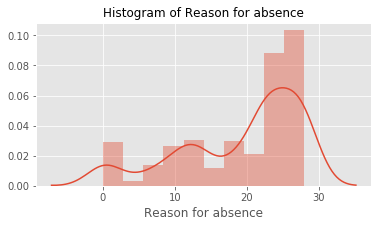

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


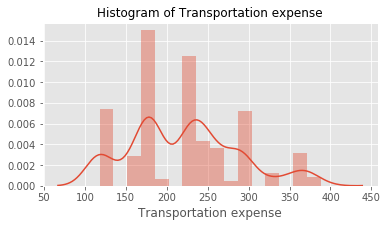

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


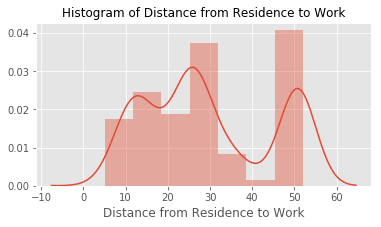

In [9]:
# Visualize the data for some of our columns to see what the distribution looks like
import seaborn as sns

for a in ['Reason for absence', 'Transportation expense', 'Distance from Residence to Work']:
    ax=plt.subplots(figsize=(6,3))
    ax=sns.distplot(absence[a])
    title="Histogram of " + a
    ax.set_title(title, fontsize=12)
    plt.show()

In [10]:
# Standardize the scaling of the columns in order to use any distance based analytical methods 
# so that we can compare the relative distances between different feature columns
# Use minmaxscaler to transform the columns so that they also fall between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
absence_scaled=pd.DataFrame(scaler.fit_transform(absence))
absence_scaled.columns=absence.columns
absence_scaled.index=absence.index

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
# See that all of our columns are now between 0 and 1
absence_scaled.describe()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,0.686293,0.527027,0.478716,0.514865,0.382703,0.524066,0.412645,0.304839,0.379108,0.715149,0.054054,0.097297,0.254730,0.567568,0.072973,0.093243,0.442983,0.276208,0.404054,0.057703
std,0.301193,0.286357,0.355419,0.370610,0.247971,0.315676,0.156603,0.208993,0.225813,0.198911,0.226277,0.224413,0.274622,0.495749,0.260268,0.164782,0.247754,0.182879,0.225550,0.111092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.464286,0.250000,0.250000,0.333333,0.225926,0.234043,0.285714,0.129032,0.222412,0.631579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.181818,0.263158,0.016667
50%,0.821429,0.500000,0.500000,0.666667,0.396296,0.446809,0.428571,0.322581,0.337244,0.736842,0.000000,0.000000,0.250000,1.000000,0.000000,0.000000,0.519231,0.212121,0.315789,0.025000
75%,0.928571,0.750000,0.750000,1.000000,0.525926,0.957447,0.535714,0.419355,0.510502,0.842105,0.000000,0.000000,0.500000,1.000000,0.000000,0.125000,0.634615,0.272727,0.631579,0.066667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# Use principal component analysis (PCA) to reduce the dimensionality of our data 
bucket='machine-learning-exam'
from sagemaker import PCA
num_components=19

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path='s3://'+ bucket +'/absence/',
             num_components=num_components)

In [13]:
# Extract the numpy array from the DataFrame and explicitly casting to float32
train_data = absence_scaled.values.astype('float32')

In [14]:
%%time
pca_SM.fit(pca_SM.record_set(train_data))

2020-02-18 02:03:36 Starting - Starting the training job...
2020-02-18 02:03:37 Starting - Launching requested ML instances......
2020-02-18 02:04:41 Starting - Preparing the instances for training......
2020-02-18 02:06:02 Downloading - Downloading input data
2020-02-18 02:06:02 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[02/18/2020 02:06:18 INFO 140378775521088] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[02/18/2020 02:06:18 INFO 140378775521088] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'20', u'mini_batch_size': u'500', u'num_components': u'19'}
[02/18/2020 02:06:18 INFO 140378775521088


2020-02-18 02:06:27 Uploading - Uploading generated training model
2020-02-18 02:06:27 Completed - Training job completed
Training seconds: 46
Billable seconds: 46
CPU times: user 415 ms, sys: 22.9 ms, total: 438 ms
Wall time: 3min 12s


In [15]:
# Store model artifacts on S3
job_name = pca_SM.latest_training_job.name
model_key = "absence/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')

0

In [16]:
# After the model is decompressed, we can load the ND array using MXNet
import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

In [17]:
# Exact explained-variance-ratio vector
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [18]:
# Calculate the variance explained by the largest n components that we want to keep. 
# Take the top 5 components
# The largest 5 components explain ~62% of the total variance in our dataset
s.iloc[14:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.622284
dtype: float32

In [19]:
# After keeping the top 5 components take only the 5 largest components from original s and v matrix
s_5=s.iloc[14:,:]
v_5=v.iloc[:,14:]
v_5.columns=[0,1,2,3,4]

In [20]:
v_5.head()

,0,1,2,3,4
0,0.407281,-0.448665,0.193074,0.289915,-0.059501
1,0.217295,-0.079499,-0.023497,-0.452234,-0.036570
2,-0.584830,-0.525670,0.547078,-0.047001,-0.035020
3,0.160280,-0.319543,-0.043324,-0.762302,0.045018
4,0.098019,0.332768,0.286093,-0.152991,-0.065728


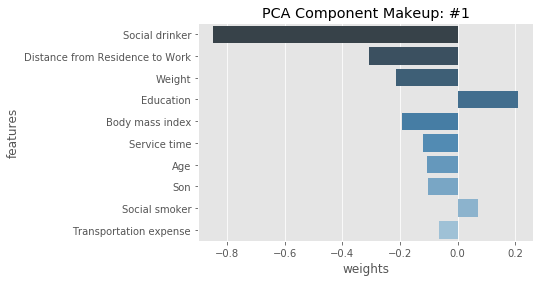

In [21]:
# Examine the makeup of one of the PCA components based on the weightings of the original features 
# that are included in the component
# Understand what the key positive and negative attributes are for the component
component_num=1

first_comp = v_5[5-component_num]
comps = pd.DataFrame(list(zip(first_comp, absence_scaled.columns)), columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

In [22]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')
# Deploy the PCA model

-----------------------!CPU times: user 354 ms, sys: 29.7 ms, total: 384 ms
Wall time: 11min 32s


In [23]:
%%time
result = pca_predictor.predict(train_data)
# Pass our original dataset to the model so that we can transform the data using the model we created
# Take the largest 5 components and this will reduce the dimensionality of our data from 19 to 5

CPU times: user 52.7 ms, sys: 0 ns, total: 52.7 ms
Wall time: 259 ms


In [24]:
# Create a dataset where each absenteeism is described by the 5 principle components
PCA_list=['Social drinker', 'Distance from Residence to Work', 'Weight', 'Education', 'Body mass index']
absence_transformed=pd.DataFrame()
for a in result:
    b=a.label['projection'].float32_tensor.values
    absence_transformed=absence_transformed.append([list(b)])
absence_transformed.index=absence_scaled.index
absence_transformed=absence_transformed.iloc[:,14:]
absence_transformed.columns=PCA_list

In [25]:
absence_transformed.head()

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index
Reason for absence,,,,,
26,0.220163,0.277262,0.023891,0.416488,-0.574165
0,-0.813139,0.473745,-0.941796,0.071819,-0.446411
23,0.119235,-0.130268,-0.052720,0.539152,-0.643213
7,-0.839607,0.590692,0.207264,0.134280,-0.147293
23,-0.115692,0.061643,0.277216,0.362107,-0.585175


In [26]:
# Use the Kmeans algorithm to segment the absenteeism by the 5 PCA attributes we have created.
train_data = absence_transformed.values.astype('float32')

In [27]:
# Find the top 7 clusters from our dataset
from sagemaker import KMeans

num_clusters = 7
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket +'/absence/',              
                k=num_clusters)

In [28]:
%%time
kmeans.fit(kmeans.record_set(train_data))

2020-02-18 02:25:53 Starting - Starting the training job...
2020-02-18 02:25:55 Starting - Launching requested ML instances......
2020-02-18 02:26:59 Starting - Preparing the instances for training...
2020-02-18 02:27:43 Downloading - Downloading input data...
2020-02-18 02:27:57 Training - Downloading the training image......
2020-02-18 02:29:22 Uploading - Uploading generated training model
2020-02-18 02:29:22 Completed - Training job completed
Docker entrypoint called with argument(s): train
[02/18/2020 02:29:13 INFO 140491501401920] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300

Training seconds: 99
Billable seconds: 99
CPU times: user 552 ms, sys: 33.4 ms, total: 586 ms
Wall time: 3min 42s


In [29]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')
# Deploy the model

-----------------------!CPU times: user 358 ms, sys: 30 ms, total: 388 ms
Wall time: 11min 32s


In [30]:
%%time
result=kmeans_predictor.predict(train_data)

CPU times: user 51.9 ms, sys: 4.45 ms, total: 56.3 ms
Wall time: 324 ms


In [31]:
# Breakdown of cluster counts and the distribution of clusters
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

In [32]:
pd.DataFrame(cluster_labels)[0].value_counts()

2.0    138
0.0    114
1.0    111
4.0    110
3.0     96
5.0     89
6.0     82
Name: 0, dtype: int64

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


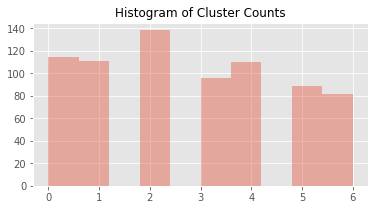

In [33]:
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [34]:
# Access the underlying model to get the cluster centers
# Centers will help describe which features characterize each cluster
# First retrieve the K-Means model attributes
job_name = kmeans.latest_training_job.name
model_key = "absence/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')

0

In [35]:
Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [36]:
# Cluster Centroid Locations: The location of the centers of each cluster identified by the Kmeans algorithm
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=absence_transformed.columns

In [37]:
cluster_centroids

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index
0,-0.194499,-0.061751,0.357695,0.185599,-0.471168
1,0.072919,0.208198,-0.263245,0.256122,0.633057
2,0.170031,0.178539,-0.110450,0.290928,-0.498988
3,0.117853,-0.079949,-0.034841,-0.466216,0.614537
4,-0.145866,-0.142386,0.292171,0.223818,0.644043
5,0.222085,-0.052123,0.152401,-0.581722,-0.477426
6,-0.341128,-0.128244,-0.547628,-0.137222,-0.414144


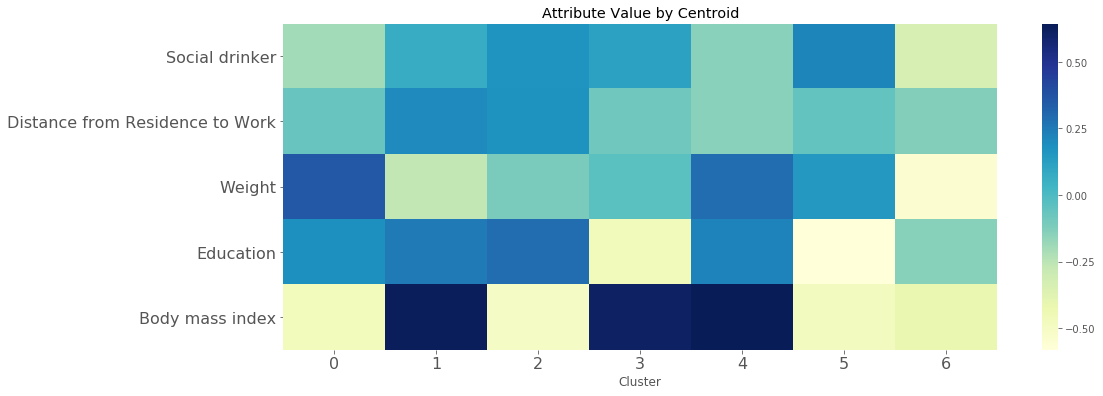

In [38]:
# Plot a heatmap of the centroids and their location in the transformed feature space
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [39]:
# Map the cluster labels back to each individual absenteeism and examine which were naturally grouped together
absence_transformed['labels']=list(map(int, cluster_labels))
absence_transformed.head()

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index,labels
Reason for absence,,,,,,
26,0.220163,0.277262,0.023891,0.416488,-0.574165,2
0,-0.813139,0.473745,-0.941796,0.071819,-0.446411,6
23,0.119235,-0.130268,-0.052720,0.539152,-0.643213,2
7,-0.839607,0.590692,0.207264,0.134280,-0.147293,0
23,-0.115692,0.061643,0.277216,0.362107,-0.585175,0


In [40]:
# Examine one of the clusters in more detail
cluster=absence_transformed[absence_transformed['labels']==1]
cluster.head(5)

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index,labels
Reason for absence,,,,,,
22,0.168640,0.200160,-0.450106,0.484331,0.634288,1
23,-0.030780,-0.020388,-0.108434,0.353993,0.284006,1
10,-0.050468,0.298167,-0.049213,0.243537,0.644102,1
18,0.045163,0.521368,-0.352631,0.338169,0.385478,1
23,0.520496,0.189885,0.255469,0.403811,0.571548,1


In [41]:
# Delete the PCA endpoint
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)

In [42]:
# Delete the K-Means endpoint
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)